<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h3><center>Andrey Shestakov (<a href="mailto:avshestakov@hse.ru">avshestakov@hse.ru</a>)</center></h3>
<hr>
<h2><center>Decision trees<sup><a href="#fn1" id="ref1">1</a></sup></center></h2>



<sup id="fn1">1. Some materials are taken from <a href="http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D1%80%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2_%28%D0%BA%D1%83%D1%80%D1%81_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B9%2C_%D0%92.%D0%92.%D0%9A%D0%B8%D1%82%D0%BE%D0%B2%29">machine learning course of Victor Kitov</a></sup>

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

try:
    from ipywidgets import interact, IntSlider, fixed, FloatSlider
except ImportError:
    print(u'Так надо')
    
import warnings
warnings.filterwarnings('ignore')

/Users/andrey.shestakov/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Let's recall previous lecture

* Metric methods: Nearest Centroid, K Nearest Neighbours
    * Work both for classification and regression
    * Lazy learning - simply remember training dataset
    * No parameters - only hyper-parameters
* Cluster hypothesis - the core of metric methods
* Similarity measures and distances: euclidean, cosine, edit-distance, Jaccard similarity, etc...
* Feature scaling is important!
* Various modifications:
    * weighted domain
    * work on "tied" cases
    * adaptive K
    * ...
* Get ready to face with
    * Curse of dimentionality
    * Slow prediction speed

# Decision trees

# Intuition

## Intuition 1

* A perfumery company developed a new unisex smell
* To find their key segments it they run open world testing
* Each respondent leaves 
    * responce if she likes it or not (`+1`|`-1`)
    * some info about her
        * Gender
        * Age
        * Education
        * Current career
        * Have domestic animals
        * etc..

## Intuition 1

In the end the description of the segments could look like this

* `[Gender = F][Age > 21][Age <= 25][Education = Higher][Have domestic animals = No]`  - like in 82% of cases
* `[Gender = M][Age > 25][Age <= 30][Current Career = Manager]` - don't like in 75% of cases
* ...


## Intuition 2

* You are going to take a loan ~~god, please, no~~ to buy something expensive, and provide your application form
* Bank employee is checking it accoring to some rules like:
    1. Current bank account > 200k rubles. - go to step 2, otherwise 3
    2. Duration < 30 months - go to step 4, otherwise REJECT
    3. Current employment > 1 year - ACCEPT, otherwise REJECT
    4. ...

## Intuition 2
<center><img src='https://mapr.com/blog/predicting-loan-credit-risk-using-apache-spark-machine-learning-random-forests/assets/blogimages/creditdecisiontree.png'><center/>

## Intuition 3

<center><img src='https://static01.nyt.com/images/2008/04/16/us/0416-nat-subOBAMA.jpg'><center/>

## Intuition 4
<center><img src='https://i.stack.imgur.com/KYSy4.png'></center>

## Intuition 4
<center><img src='img/Decision_tree_model.png'></center>

<center><img src='http://scikit-learn.org/stable/_static/ml_map.png'><center/>

<center><img src='https://eight2late.files.wordpress.com/2016/02/7214525854_733237dd83_z1.jpg?w=700'><center/>

## Definition of decision tree

* Prediction is performed by tree $T$ (directed, connected, acyclic graph)

* Node types
    1. A root node, $root(T)$
    2. Internal nodes $int(T)$, each having $\ge2$ child nodes
    3. Terminal nodes (leafs), $terminal(T)$, which do not have child nodes but have associated prediction values


## Definition of decision tree

* for each non-terminal node $t$ a **check-function** $Q_{t}(x)$ is associated 
* for each edge $r_{t}(1),...r_{t}(K_{t})$ a set of values of check-function
$Q_{t}(x)$ is associated: $S_{t}(1),...S_{t}(K_{t})$ such that:
    * $\bigcup_{k}S_{t}(k)=range[Q_{t}]$ 
    * $S_{t}(i)\cap S_{t}(j)=\emptyset$ $\forall i\ne j$

## Prediction process

* Prediction is easy if we have already constructed a tree
* Prediction process for tree $T$:
    * $t=root(T)$
    * while $t$ is not a terminal node:

        * calculate $Q_{t}(x)$
        * determine $j$ such that $Q_{t}(x)\in S_{t}(j)$
        * follow edge $r_{t}(j)$ to $j$-th child node: $t=\tilde{t}_{j}$
    * return prediction, associated with leaf $t$.


## Specification of decision tree
* To define a decision tree one needs to specify:
    * the check-function: $Q_{t}(x)$ 
    * the splitting criterion: $K_{t}$ and $S_{t}(1),...S_{t}(K_{t})$
    * the termination criteria (when node is defined as a terminal node)
    * the predicted value for each leaf node.

## Genralized decision tree algorithm

```{python}
1. function decision_tree(X, y):

2.    if termination_criterion(X, y) == True:
    
3.        S = create_leaf_with_prediction(y)
        
4.    else:
    
5.        S = create_node()
6.        (X_1, y_1) .. (X_L, y_L) = best_split(X, y)
        
7.        for i in 1..L:
8.            C = decision_tree(X_i, y_i)
9.            connect_nodes(S, C)
10.   return S     
```

# Splitting rules

## Possible definitions of splitting rules

* $Q_{t}(x)=x^{i(t)}$, where $S_{t}(j)=v_{j}$, where $v_{1},...v_{K}$ are unique values of feature $x^{i(t)}$.
* $S_{t}(1)=\{x^{i(t)}\le h_{t}\},\,S_{t}(2)=\{x^{i(t)}>h_{t}\}$
* $S_{t}(j)=\{h_{j}<x^{i(t)}\le h_{j+1}\}$ for set of partitioning thresholds $h_{1},h_{2},...h_{K_{t}+1}$.
* $S_{t}(1)=\{x:\,\langle x,v\rangle\le0\},\quad S_{t}(2)=\{x:\,\langle x,v\rangle>0\}$
* $S_{t}(1)=\{x:\,\left\lVert x\right\rVert \le h\},\quad S_{t}(2)=\{x:\,\left\lVert x\right\rVert >h\}$
* etc.


## Most famous decision tree algorithms

* C4.5
* ID 3
* CART (classification and regression trees)
    * implemented in scikit-learn (kind of)

## CART version of splitting rule

* single feature value is considered:
$$
Q_{t}(x)=x^{i(t)}
$$
* binary splits:
$$
K_{t}=2
$$
* split based on threshold $h_{t}$:
$$
S_{1}=\{x^{i(t)}\le h_{t}\},\,S_{2}=\{x^{i(t)}>h_{t}\}
$$
* $h(t)\in\{x_{1}^{i(t)},x_{2}^{i(t)},...x_{N}^{i(t)}\}$

    * applicable only for real, ordinal and binary features
    * what about categorical features?

# Splitting rule selection

## Intuition

Which box is better to predict color

<center><img src='img/bins.png'></center>


## Classification impurity functions

* For classification: let $p_{1},...p_{C}$ be class probabilities for objects in node $t$.
* Then impurity function $\phi(t)=\phi(p_{1},p_{2},...p_{C})$ should satisfy:

    * $\phi$ is defined for $p_{j}\ge0$ and $\sum_{j}p_{j}=1$.
    * $\phi$ attains maximum for $p_{j}=1/C,\,k=1,2,...C$ .
    * $\phi$ attains minimum when $\exists j:\,p_{j}=1,\,p_{i}=0$ $\forall i\ne j$.
    * $\phi$ is symmetric function of $p_{1},p_{2},...p_{C}$.


## Typical classification impurity functions}

* **Gini criterion**

    * interpretation: probability to make mistake when predicting class randomly with class probabilities $[p(\omega_{1}|t),...p(\omega_{C}|t)]$:
$$
I(t)=\sum_{i}p(\omega_{i}|t)(1-p(\omega_{i}|t))=1-\sum_{i}[p(\omega_{i}|t)]^{2}
$$

* **Entropy**

    * interpretation: measure of uncertainty of random variable
$$
I(t)=-\sum_{i}p(\omega_{i}|t)\ln p(\omega_{i}|t)
$$

* **Classification error**
     * interpretation: frequency of errors when classifying with the most common class
$$
I(t)=1-\max_{i}p(\omega_{i}|t)
$$

In [3]:
def plot_impurities():
    p = np.linspace(0, 1, 100)
    p = np.c_[p, 1-p]

    missclass = 1 - p.max(axis=1)
    plt.plot(p[:,0], missclass, label = 'missclassification error')

    gini = 1 - (p ** 2).sum(axis=1)
    plt.plot(p[:,0], gini, label = 'gini index')

    entropy = - np.nansum((p*np.log2(p)), axis=1)
    plt.plot(p[:,0], entropy, label = 'entropy')

    plt.xlabel('$p(\omega_1|t)$')
    plt.ylabel('$I(t)$')
    # plt.legend(loc=2, bbox_to_anchor=(0.,0.))
    plt.legend(loc=2, bbox_to_anchor=(-0.3,1))
    
    plt.show()

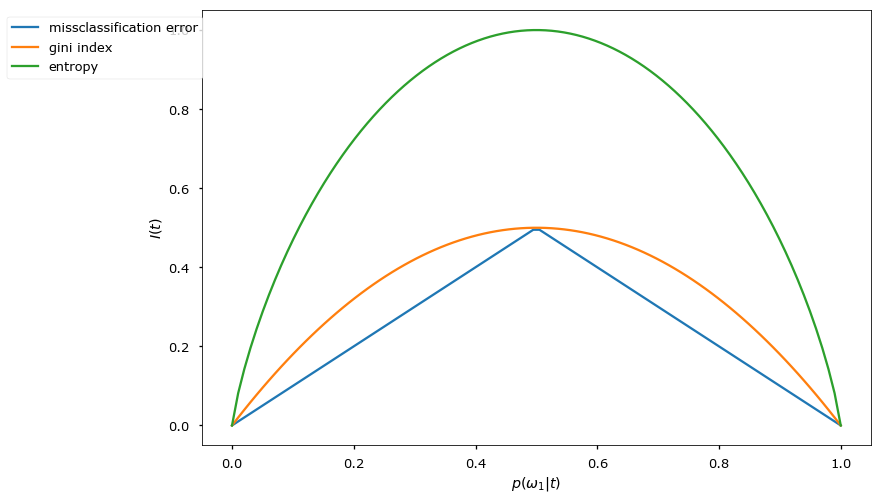

In [4]:
plot_impurities()

## Splitting criterion selection

* Define $\Delta I(t)$ - is the quality of the split of node $t$ into child nodes $t_{1},...t_{C}$.
$$
\Delta I(t)=I(t)-\sum_{i=1}^{C}I(t_{i})\frac{N(t_{i})}{N(t)}
$$
$$
\Delta I(t)=I(t)-\left(I(t_{L})\frac{N(t_{L})}{N(t)} + I(t_{R})\frac{N(t_{R})}{N(t)}\right)
$$

    * If $I(t)$ is entropy, then $\Delta I(t)$ is called *information gain*.


* CART optimization (regression, classification): select feature $i_{t}$ and threshold $h_{t}$, which maximize $\Delta I(t)$:
$$
i_{t},\,h_{t}=\arg\max_{k,h}\Delta I(t)
$$
* CART decision making: from node $t$ follow: 

$$\begin{cases}
\text{left child }t_{1}, & \text{if }x^{i_{t}}\le h_{t}\\
\text{right child }t_{2}, & \text{if }x^{i_{t}}>h_{t}
\end{cases}$$


## Splitting criterion selection

**Remarks**
* Local and Greedy optimization
* Overall results changes slighly with different impurity measures


In [5]:
def impurity(p): 
    return -np.sum(p*np.log(p))

def wine_demo():

    df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

    fig, ax = plt.subplots(1, 2, figsize=(16,6))

    fig.set_figheight(5)

    df_wine.loc[:, 'quality_cat'] = (df_wine.loc[:, 'quality'] > 5).astype(int) 
    idx = df_wine.loc[:, 'quality_cat'] == 1
    df_wine.loc[idx, 'alcohol'].hist(label='good quality', bins=20, alpha = 0.4, ax=ax[0])
    df_wine.loc[~idx, 'alcohol'].hist(label='bad quality', bins=20, alpha = 0.4, ax=ax[0])
    ax[0].set_xlabel('alcohol')

    p = np.array([df_wine.quality_cat.mean(), 1-df_wine.quality_cat.mean()])

    init_impurity = impurity(p)

    G = []
    t_range = np.linspace(df_wine.alcohol.min(), df_wine.alcohol.max(), 100)

    for t in t_range:
        idx = df_wine.alcohol < t
        p1 = np.array([df_wine.loc[idx, 'quality_cat'].mean(), 1-df_wine.loc[idx, 'quality_cat'].mean()])
        p2 = np.array([df_wine.loc[~idx, 'quality_cat'].mean(), 1-df_wine.loc[~idx, 'quality_cat'].mean()])

        G.append(init_impurity - (idx.mean()*impurity(p1) + (1-idx.mean())*impurity(p2)))

    ax[1].plot(t_range, G)
    ax[1].set_xlabel('alcohol')
    ax[1].set_ylabel('Gain')

    mG = np.nanmax(G)
    mt = t_range[np.nanargmax(G)]

    ax[0].vlines(mt, 0, 150, label='best threshold (%.2f)' % mt)
    ax[1].vlines(mt, 0, mG, label='best threshold\n(gain = %.4f)' % mG)
    
    ax[0].legend()
    ax[1].legend()
    
    plt.show()

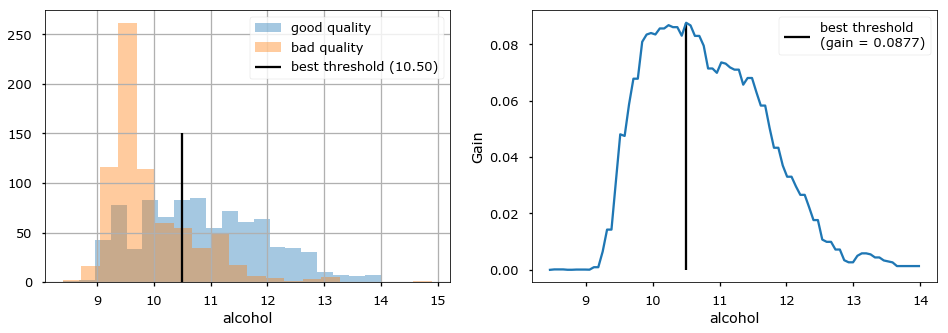

In [6]:
wine_demo() 

## Typical regression impurity functions

* Impurity function measures uncertainty in $y$ for objects falling inside node $t$.
    * Regression:
        * let objects falling inside node $t$ be $I=\{i_{1},...i_{K}\}$. We may define
\begin{align*}
\phi(t) & =\frac{1}{K}\sum_{i\in I}\left(y_{i}-\mu\right)^{2}\quad \text{(MSE)}\\
\phi(t) & =\frac{1}{K}\sum_{i\in I}|y_{i}-\mu|\quad \text{(MAE)}
\end{align*}
where $\mu$ is `mean` or  `median` of $y_i$s.


## Prediction assignment to leaves

* Regression:
    * mean (optimal for MSE loss)
    * median (optimal for MAE loss)


* Classification
    * most common class (optimal for constant misclassification cost)

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from ipywidgets import interact, IntSlider
import subprocess


def demo_dec_tree(depth=1):
    fig, ax = plt.subplots(1,2, figsize=(18,8))

    np.random.seed(0)

    C = np.array([[0., -0.7], [1.5, 0.7]])
    gauss1 = np.dot(np.random.randn(200, 2) + np.array([4, 2]), C)
    gauss2 = np.dot(np.random.randn(300, 2), C)

    X = np.vstack([gauss1, gauss2])
    y = np.r_[np.ones(200), np.zeros(300)]

    ax[1].scatter(X[:,0], X[:, 1], c=y)
    ax[1].set_xlabel('$x_1$')
    ax[1].set_ylabel('$x_2$')

    # Dec Tree Stuff
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=123)
    tree.fit(X,y)

    x_range = np.linspace(X.min(), X.max(), 100)
    xx1, xx2 = np.meshgrid(x_range, x_range)

    Y = tree.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Y = Y.reshape(xx1.shape)

    ax[1].contourf(xx1, xx2, Y, alpha=0.3, cmap=plt.cm.flag)
    ax[1].scatter(X[:,0], X[:,1],c=y, cmap=plt.cm.flag)
    
    
    try:
        with open('tree.dot', 'w') as fout:
            export_graphviz(tree, out_file=fout, feature_names=['x1', 'x2'], class_names=['0', '1'])
        command = ["dot", "-Tpng", "tree.dot", "-o", "tree.png"]
        subprocess.check_call(command)
        ax[0].imshow(plt.imread('tree.png'))
        ax[0].axis("off")
    except:
        print('Скорее всего не установлен graphviz')
        
    plt.show()

## Classification example

In [8]:
fig = interact(demo_dec_tree, depth=IntSlider(min=1, max=5, value=1))

interactive(children=(IntSlider(value=1, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

In [9]:
from sklearn.tree import DecisionTreeRegressor

x_true = np.arange(-5, 5, 0.2)
x = x_true + np.random.rand(x_true.shape[0]) - 0.5
y_true = np.sin(x_true)+x_true/3
y = y_true + np.random.rand(x_true.shape[0]) - 0.5

def plot_dec_reg(depth=1, criterion='mse', ):
    
    fig, ax = plt.subplots(1,2,figsize=(18,8))
    fig.set_figheight(5)
    
    tree = DecisionTreeRegressor(criterion=criterion, max_depth=depth)
    tree.fit(x.reshape(-1,1), y)
    y_hat = tree.predict(x_true.reshape(-1,1))
    
    ax[1].plot(x_true, y_true, c='g', label='$f(x)$')
    ax[1].scatter(x, y, label='actual data')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    ax[1].plot(x_true, y_hat, c='r', label='decision tree \nregression')
    ax[1].legend(loc=2)
    
    try:
        with open('tree.dot', 'w') as fout:
            export_graphviz(tree, out_file=fout, feature_names=['x'])
        command = ["dot", "-Tpng", "tree.dot", "-o", "tree.png"]
        subprocess.check_call(command)
        ax[0].imshow(plt.imread('tree.png'))
        ax[0].axis("off")
    except:
        print('Скорее всего не установлен graphviz')
        
    plt.show()

## Regression example

In [10]:
fig = interact(plot_dec_reg, depth=IntSlider(min=1, max=5, value=1), criterion=['mse', 'mae'])

interactive(children=(IntSlider(value=1, description='depth', max=5, min=1), Dropdown(description='criterion',…

# Termination criterion

## Termination criterion

* Tradeoff:
    * very large complex trees -> overfitting
    * very short simple trees -> underfitting


* Approaches to stopping:
    * rule-based
    * based on pruning (not considered here)

## Rule-base termination criteria

* Rule-based: a criterion is compared with a threshold.
* Variants of criterion:
    * depth of tree
    * number of objects in a node
    * minimal number of objects in one of the child nodes
    * impurity of classes
    * change of impurity of classes after the split
    * etc

## Analysis of rule-based termination

Advantages:
* simplicity
* interpretability

Disadvantages:
* specification of threshold is needed

# Other features

## Tree feature importances

* Consider feature $f$
* Let $T(f)$ be the set of all nodes, relying on feature $f$ when making split.
    * efficiency of split at node $t$: $\Delta I(t)=I(t)-\sum_{c\in childen(t)}\frac{n_{c}}{n_{t}}I(c)$
    * feature importance of $f$: $\sum_{t\in T(f)}n_{t}\Delta I(t)$


* Alternative: difference in decision tree prediction quality for
    * original validation set
    * validation set with $j$-th feature randomly shuffled

## Handling missing values

1. Remove features or objects with missing values
2. Missing value = distinct feature value
3. Calculation of impurity w/o missing cases
4. **Surrogate split!**
    * Find best split with feature $i^*$, threshold $h^*$ and children $\{t^*_L, t^*_R\}$
    * Find other good splits for features $i_t \neq i^*$, s.t. $\{t_L, t_R\} \approx \{t^*_L, t^*_R\}$
    * While performing prediction of object $x$:
        * If $x^{i^*}$ is `Null`, try $x^{i_t}$

## Analysis of decision trees

* **Advantages:**

    * simplicity of algorithm
    * interpretability of model (for short trees)
    * implicit feature selection
    * good for features of different nature:
        * naturally handles both discrete and real features
        * prediction is invariant to monotone transformations of features

## Analysis of decision trees


* **Disadvantages:**
    * not very high accuracy:
        * high overfitting of tree structure up to top
        * non-parallel to axes class separating boundary may lead to many nodes in the tree for $Q_{t}(x)=x^{i(t)}$
        * one step ahead lookup strategy for split selection may be insufficient (XOR example)
    * not online - slight modification of the training set will require full tree reconstruction.

## Special Desicion Tree Algorithms
 
 
**ID 3**
* Categorical features only
* Number of children = number of categories
* Maximum depth

**С 4.5**
* Handling continious features
* And categorical as in ID3
* Find missing value - proceed down to all paths and average
* Some prunning procedure

## Interpretation of DT
<center><img src='img/trees-interpr.png' width='750'></center>

* http://blog.datadive.net/interpreting-random-forests/
* https://eli5.readthedocs.io/en/latest/

## FYI
* [How tree works](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)